In [2]:
#Oppgave 2
import requests
import pandas as pd
import json
from pandasql import sqldf

# Henter inn dataen
API_URL = "https://api.met.no/weatherapi/locationforecast/2.0/compact"
headers = {"User-Agent": "MyWeatherApp/1.0 (contact@example.com)", "Accept": "application/json"}
params = {"lat": 59.91, "lon": 10.75}  # Oslo koordinater

response = requests.get(API_URL, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()
    with open("../data/weather_data.json", "w") as f:
        json.dump(data, f, indent=4)
    print("Data hentet og lagret som JSON")
else:
    print("Feil ved henting av data! Statuskode:", response.status_code)
    exit()

#Behandler data med Pandas
timeseries = data["properties"]["timeseries"]
rows = []

for entry in timeseries:
    time = entry["time"]
    details = entry["data"]["instant"]["details"]
    rows.append({"Tidspunkt": time, **details})

df = pd.DataFrame(rows)

#Oversetter til norsk
column_mapping = {
    "air_pressure_at_sea_level": "Lufttrykk ved havnivå",
    "air_temperature": "Lufttemperatur",
    "wind_speed": "Vindhastighet",
    "wind_from_direction": "Vindretning",
    "relative_humidity": "Relativ fuktighet",
    "cloud_area_fraction": "Skydekke"
}
df.rename(columns=column_mapping, inplace=True)

df.to_csv("../data/weather_data.csv", index=False)
print("Data lagret som CSV")

#Vurdering av kilde
source_info = {
    "Kilde": "MET Norway",
    "Pålitelighet": "Høy",
    "Tilgjengelighet": "Åpen tilgang, krever User-Agent header",
    "Format": "JSON",
    "Oppdateringsfrekvens": "Løpende oppdateringer",
}
print("Vurdering av kilde:")
for key, value in source_info.items():
    print(f"{key}: {value}")

#Data analyse med PandaSQL
pysqldf = lambda q: sqldf(q, globals())
query = """
SELECT Tidspunkt, Lufttemperatur, Vindhastighet
FROM df
WHERE Lufttemperatur IS NOT NULL
ORDER BY Tidspunkt ASC
LIMIT 5;
"""
result = pysqldf(query)
print("\nEksempel på analyserte data:")
print(result)



Data hentet og lagret som JSON
Data lagret som CSV
Vurdering av kilde:
Kilde: MET Norway
Pålitelighet: Høy
Tilgjengelighet: Åpen tilgang, krever User-Agent header
Format: JSON
Oppdateringsfrekvens: Løpende oppdateringer

Eksempel på analyserte data:
              Tidspunkt  Lufttemperatur  Vindhastighet
0  2025-04-22T12:00:00Z             9.1            2.7
1  2025-04-22T13:00:00Z             9.1            2.9
2  2025-04-22T14:00:00Z             9.1            2.7
3  2025-04-22T15:00:00Z             9.2            2.5
4  2025-04-22T16:00:00Z             9.2            2.0


In [3]:
#Oppgave 3
#Håndtering av manglende verdier 
def clean_data(df):
    df.dropna(inplace=True)  
    return df

df_cleaned = clean_data(df)
print("\nData etter håndtering av manglende verdier:")
print(df_cleaned.head())

#List comprenhensions 
df_cleaned["Tidspunkt"] = [t.replace("T", " ") for t in df_cleaned["Tidspunkt"]]
print("\nTidspunkt formatert:")
print(df_cleaned["Tidspunkt"].head())

#Manipulerer data med Pandas SQL 
query = """
SELECT Tidspunkt, Lufttemperatur, Vindhastighet
FROM df_cleaned
WHERE Lufttemperatur > 0
ORDER BY Vindhastighet DESC
LIMIT 5;
"""
result = pysqldf(query)
print("\nEksempel på filtrerte data:")
print(result)

#Forventede uregelmessigheter og håndtering
print("\nForventede uregelmessigheter og håndtering:")
print("- Manglende verdier: Løst med dropna().")
print("- Uregelmessige tidspunkter: Formatert med list comprehension.")
print("- Ekstreme verdier: Kan analyseres med ytterligere filtrering.")



Data etter håndtering av manglende verdier:
              Tidspunkt  Lufttrykk ved havnivå  Lufttemperatur  Skydekke  \
0  2025-04-22T12:00:00Z                 1015.6             9.1     100.0   
1  2025-04-22T13:00:00Z                 1015.5             9.1     100.0   
2  2025-04-22T14:00:00Z                 1015.5             9.1     100.0   
3  2025-04-22T15:00:00Z                 1015.7             9.2     100.0   
4  2025-04-22T16:00:00Z                 1015.8             9.2     100.0   

   Relativ fuktighet  Vindretning  Vindhastighet  
0               86.9         50.3            2.7  
1               86.8         44.3            2.9  
2               86.2         46.2            2.7  
3               85.6         49.0            2.5  
4               84.9         45.4            2.0  

Tidspunkt formatert:
0    2025-04-22 12:00:00Z
1    2025-04-22 13:00:00Z
2    2025-04-22 14:00:00Z
3    2025-04-22 15:00:00Z
4    2025-04-22 16:00:00Z
Name: Tidspunkt, dtype: object

Eksempel

Statistiske mål:
Korrelasjon mellom lufttemperatur og vindhastighet: 0.60
Antall observasjoner uten skjevheter (temperatur): 83 av 86


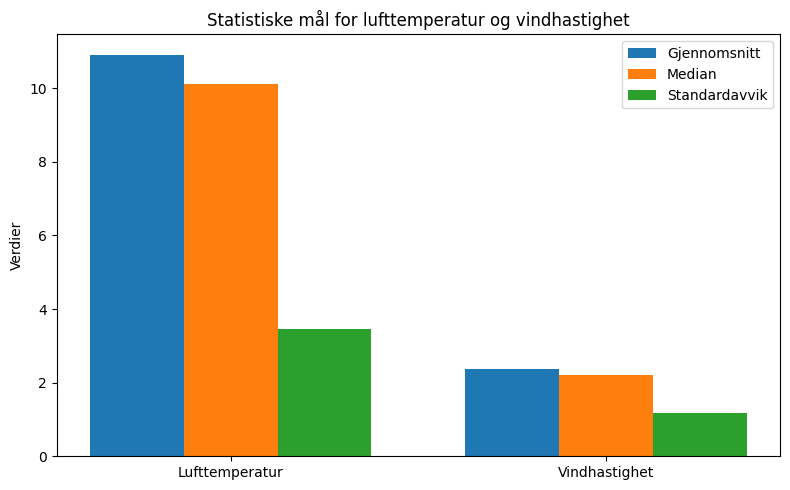

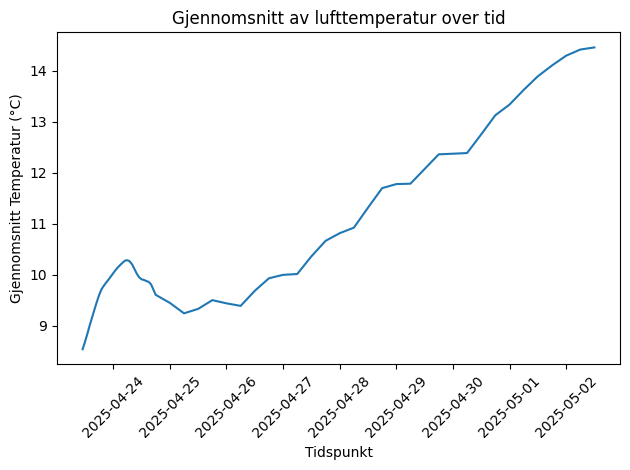

In [4]:
#Oppgave 4
import numpy as np
import matplotlib.pyplot as plt


#Konverterer kolonner til NumPy-arrays
temp_arr = df_cleaned['Lufttemperatur'].to_numpy()
wind_arr = df_cleaned['Vindhastighet'].to_numpy()

stats = {
    'Lufttemperatur': {
        'gjennomsnitt': np.mean(temp_arr),
        'median': np.median(temp_arr),
        'standardavvik': np.std(temp_arr, ddof=1)
    },
    'Vindhastighet': {
        'gjennomsnitt': np.mean(wind_arr),
        'median': np.median(wind_arr),
        'standardavvik': np.std(wind_arr, ddof=1)
    }
}
print("Statistiske mål:")

#Korrelasjonsanalyse mellom lufttemperatur og vindhastighet
korrelasjon = df_cleaned['Lufttemperatur'].corr(df_cleaned['Vindhastighet'])
print(f"Korrelasjon mellom lufttemperatur og vindhastighet: {korrelasjon:.2f}")

#Håndtere skjevheter basert på IQR (Interquatile Range)
Q1 = df_cleaned['Lufttemperatur'].quantile(0.25)
Q3 = df_cleaned['Lufttemperatur'].quantile(0.75)
IQR = Q3 - Q1
mask_iqr = (
    (df_cleaned['Lufttemperatur'] >= Q1 - 1.5 * IQR) &
    (df_cleaned['Lufttemperatur'] <= Q3 + 1.5 * IQR)
)
df_no_outliers = df_cleaned[mask_iqr]
print(f"Antall observasjoner uten skjevheter (temperatur): {len(df_no_outliers)} av {len(df_cleaned)}")


# Forbereder data for plotting med matplotlib
types = list(stats.keys())
means = [stats[t]['gjennomsnitt'] for t in types]
medians = [stats[t]['median'] for t in types]
stds = [stats[t]['standardavvik'] for t in types]

x = range(len(types))
width = 0.25

plt.figure(figsize=(8, 5))

plt.bar([p - width for p in x], means, width=width, label='Gjennomsnitt')
plt.bar(x, medians, width=width, label='Median')
plt.bar([p + width for p in x], stds, width=width, label='Standardavvik')

plt.xticks(x, types)
plt.ylabel('Verdier')
plt.title('Statistiske mål for lufttemperatur og vindhastighet')
plt.legend()
plt.tight_layout()
plt.show()


#Finne og visualiser mønstre i data
window = 24
temp_arr = df_cleaned['Lufttemperatur'].to_numpy()

weights = np.ones(window) / window  
moving_avg = np.convolve(temp_arr, weights, mode='valid')


times = pd.to_datetime(df_cleaned['Tidspunkt']).to_numpy()
times_ma = times[window-1:]


plt.figure()
plt.plot(times_ma, moving_avg)
plt.xlabel('Tidspunkt')
plt.ylabel('Gjennomsnitt Temperatur (°C)')
plt.title('Gjennomsnitt av lufttemperatur over tid')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





C:\Users\Thinkpad\AppData\Local\Temp\ipykernel_5660\2714218634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Tidspunkt_dt'] = pd.to_datetime(df_no_outliers['Tidspunkt'])


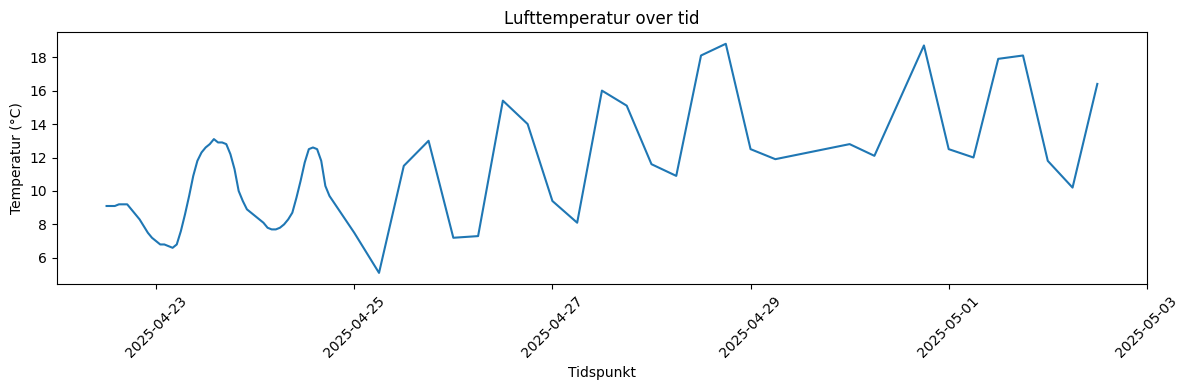

Luftemperatur over tid:


,Dato,Klokkeslett,Lufttemperatur
0,2025-04-22,12:00,9.100000
6,2025-04-22,18:00,8.900000
12,2025-04-23,00:00,7.000000
18,2025-04-23,06:00,7.600000
24,2025-04-23,12:00,12.600000
30,2025-04-23,18:00,12.200000
36,2025-04-24,00:00,8.500000
42,2025-04-24,06:00,7.800000
48,2025-04-24,12:00,11.700000
54,2025-04-24,18:00,9.700000


Høyeste temperatur hver dag:


,Dato,Lufttemperatur
0,2025-04-22,9.200000
1,2025-04-23,13.100000
2,2025-04-24,12.600000
3,2025-04-25,13.000000
4,2025-04-26,15.400000
5,2025-04-27,16.000000
6,2025-04-28,18.800000
7,2025-04-29,12.500000
8,2025-04-30,18.700000
9,2025-05-01,18.100000


interactive(children=(IntSlider(value=24, description='Vindu:', max=72, min=2), Output()), _dom_classes=('widg…

<function __main__.plot_moving_average(window=24)>

In [5]:
#Oppgave 5
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Lufttemperatur over tid
df_no_outliers['Tidspunkt_dt'] = pd.to_datetime(df_no_outliers['Tidspunkt'])
plt.figure(figsize=(12, 4))
sns.lineplot(x='Tidspunkt_dt', y='Lufttemperatur', data=df_no_outliers)
plt.xlabel('Tidspunkt')
plt.ylabel('Temperatur (°C)')
plt.title('Lufttemperatur over tid')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Temperatur ved spesifikke tidspunkter

print("Luftemperatur over tid:")
selected_hours = [0, 6, 12, 18]
df_times = df_no_outliers.copy()
df_times['Tidspunkt_dt'] = pd.to_datetime(df_times['Tidspunkt'])
df_times['Dato'] = df_times['Tidspunkt_dt'].dt.date
df_times['Klokkeslett'] = df_times['Tidspunkt_dt'].dt.strftime('%H:%M')
df_table = df_times[df_times['Tidspunkt_dt'].dt.hour.isin(selected_hours)][['Dato', 'Klokkeslett', 'Lufttemperatur']]

#Legger til farger
styler = df_table.style.map(
    lambda v: 'background-color: red' if v > 14 else ('background-color: blue' if v < 8 else 'background-color: white'),
    subset=['Lufttemperatur']
)

display(styler)

#Høyeste lufttemperatur
print("Høyeste temperatur hver dag:")

df_temp = df_no_outliers.copy()
df_temp['Dato'] = pd.to_datetime(df_temp['Tidspunkt']).dt.date
daily_max = df_temp.groupby('Dato')['Lufttemperatur'].max().reset_index()

#Legger til farger
styler_max = daily_max.style.map(
    lambda v: 'background-color: red' if v > 14 else ('background-color: blue' if v < 8 else 'background-color: white'),
    subset=['Lufttemperatur']
)

display(styler_max)


from ipywidgets import interact, IntSlider

#Interaktiv visualisering
def plot_moving_average(window=24):
    arr = df_no_outliers['Lufttemperatur'].to_numpy()
    if window < 1 or window > len(arr):
        return
    weights = np.ones(window) / window
    ma = np.convolve(arr, weights, mode='valid')
    times = pd.to_datetime(df_no_outliers['Tidspunkt']).to_numpy()[window-1:]

    plt.figure(figsize=(10, 4))
    plt.plot(times, ma)
    plt.xlabel('Tidspunkt')
    plt.ylabel(f'Glidende gjennomsnitt ({window}-punkter)')
    plt.title('Interaktiv glidende gjennomsnitt av lufttemperatur')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Slider
display(interact(plot_moving_average, window=IntSlider(min=2, max=72, step=1, value=24, description='Vindu:')))


MSE test: 4.11
R2 test: 0.61


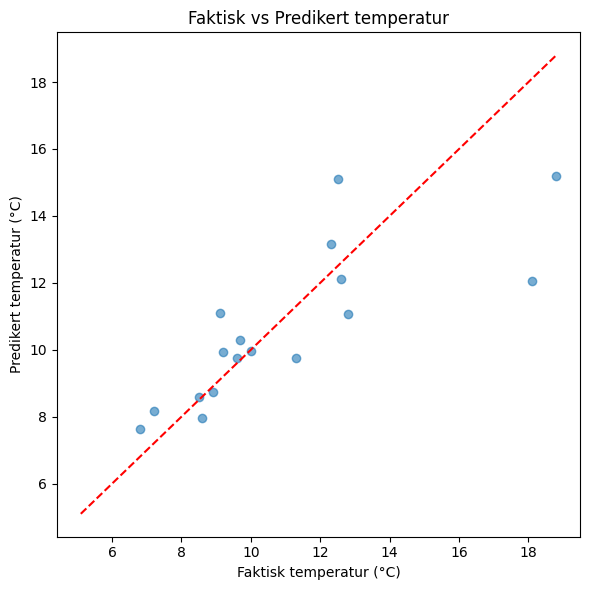

c:\Users\Thinkpad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Thinkpad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\util

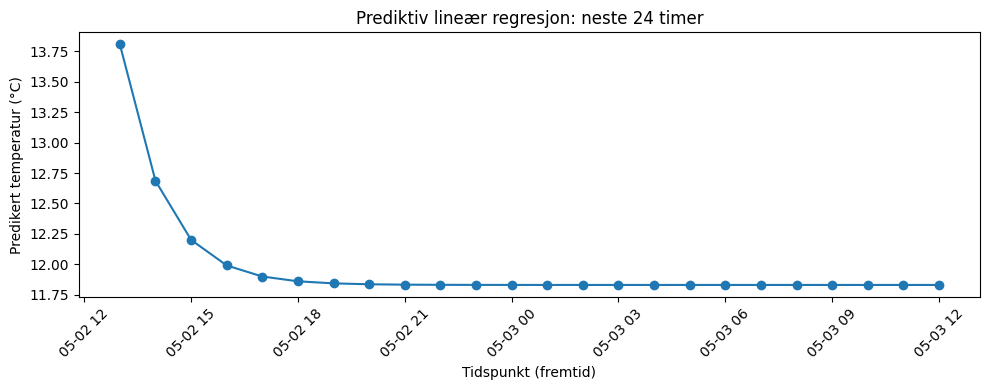

In [10]:
#Oppgave 6
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Funksjoner for målinger
df_pred = df_no_outliers.copy()
df_pred['temp_t-1'] = df_pred['Lufttemperatur'].shift(1)
df_pred['wind_t'] = df_pred['Vindhastighet']
df_pred['press_t'] = df_pred['Lufttrykk ved havnivå']

df_pred.dropna(inplace=True)

#Features og target
def_cols = ['temp_t-1', 'wind_t', 'press_t']
X = df_pred[def_cols]
y = df_pred['Lufttemperatur']

# Splitte data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Lineær regresjon
model = LinearRegression()
model.fit(X_train, y_train)

#Finner feil og nøyaktighet
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE test: {mse:.2f}")
print(f"R2 test: {r2:.2f}")

#Scatterplot av faktisk vs predikert temperatur
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Faktisk temperatur (°C)')
plt.ylabel('Predikert temperatur (°C)')
plt.title('Faktisk vs Predikert temperatur')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.tight_layout()
plt.show()

#Prediksjon for neste 24 timer
future_preds = []
last_row = df_pred.iloc[-1][['Lufttemperatur', 'Vindhastighet', 'Lufttrykk ved havnivå']]
for i in range(24):
    features = [[last_row['Lufttemperatur'], last_row['Vindhastighet'], last_row['Lufttrykk ved havnivå']]]
    p = model.predict(features)[0]
    future_preds.append(p)
    last_row['Lufttemperatur'] = p

# Visualiser prediksjoner
future_times = pd.date_range(start=pd.to_datetime(df_no_outliers['Tidspunkt']).iloc[-1] + pd.Timedelta(hours=1), periods=24, freq='h')
plt.figure(figsize=(10, 4))
plt.plot(future_times, future_preds, marker='o')
plt.xlabel('Tidspunkt (fremtid)')
plt.ylabel('Predikert temperatur (°C)')
plt.title('Prediktiv lineær regresjon: neste 24 timer')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
